In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:.4f}'.format)

import warnings
warnings.filterwarnings("ignore")

# Импорт данных и общий обзор

Датасет — test_atm_analysis.csv

В датасете инфомрация о операциях снятия и внесения денежных средств в банкоматах.

Описание полей:
- TIME – дата время совершения операции;
- TRANSACTION_ID – id операции;
- AMOUNT – сумма операции;
- CLIENT_ID -  id клиента;
- BANK_ID – id банка, которому принадлежит банкомат;
- CITY -  местоположение банкомата;
- OPERATION_TYPE – тип операции;
- FRAUD_FLAG – признак фрода, 1 — фрод, 0 — обычная операциях

In [2]:
df = pd.read_csv("test_atm_analysis.csv", parse_dates=['TIME'])
df.shape

(873843, 8)

In [3]:
df.sort_values(by="TIME", inplace=True)
df.reset_index(inplace=True, drop=True)
df[:5]

,TIME,TRANSACTION_ID,AMOUNT,CLIENT_ID,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG
0,2023-05-01 00:00:00,525471383640,1560,BD308B1E6247DAD7E7FAC425AB3CADA464C26F2A0B47EB...,6,VSEVOLOZHSK,Снятие через банкоматы партнеров,0
1,2023-05-01 00:00:00,525471381920,1560,BD308B1E6247DAD7E7FAC425AB3CADA464C26F2A0B47EB...,6,VSEVOLOZHSK,Снятие через банкоматы партнеров,0
2,2023-05-01 00:03:26,525487382296,290,2E021B8D64532F869A14167A6075996B903D52ED66B3AD...,6,OBNINSK,Снятие через банкоматы партнеров,0
3,2023-05-01 00:08:17,525364464247,310,B27401D40DC566402D47BA342DDD6A1457E91F3D211D0B...,3,CHITA G,Пополнение через банкоматы партнеров,0
4,2023-05-01 00:11:23,525513617413,140,B566176D8952A9B1AA4A25D1574AE1CA9EA57C2AB4F29C...,2,DALNEGORSK,Снятие через чужие банкоматы,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873843 entries, 0 to 873842
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   TIME            873843 non-null  datetime64[ns]
 1   TRANSACTION_ID  873843 non-null  int64         
 2   AMOUNT          873843 non-null  int64         
 3   CLIENT_ID       873843 non-null  object        
 4   BANK_ID         873843 non-null  int64         
 5   CITY            873642 non-null  object        
 6   OPERATION_TYPE  873843 non-null  object        
 7   FRAUD_FLAG      873843 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 53.3+ MB


Проверим датасет на пропуски

In [5]:
round(df.isna().sum() / df.shape[0] * 100, 2)

TIME             0.0000
TRANSACTION_ID   0.0000
AMOUNT           0.0000
CLIENT_ID        0.0000
BANK_ID          0.0000
CITY             0.0200
OPERATION_TYPE   0.0000
FRAUD_FLAG       0.0000
dtype: float64

In [6]:
df.describe()

,TIME,TRANSACTION_ID,AMOUNT,BANK_ID,FRAUD_FLAG
count,873843,873843.0000,873843.0000,873843.0000,873843.0000
mean,2023-06-16 03:15:43.432114432,535908198467.6913,651.0136,2.6414,0.0006
min,2023-05-01 00:00:00,524834800723.0000,0.0000,1.0000,0.0000
25%,2023-05-24 09:24:00,530559823478.5000,160.0000,1.0000,0.0000
50%,2023-06-16 10:30:16,536102209758.0000,330.0000,1.0000,0.0000
75%,2023-07-08 13:06:01,541667928702.5000,610.0000,3.0000,0.0000
max,2023-07-31 23:59:36,547776931426.0000,156590.0000,47.0000,1.0000
std,NaN,6382374770.7073,1315.7372,3.7192,0.0244


In [7]:
df.describe(include=["object", "bool", "category"])

,CLIENT_ID,CITY,OPERATION_TYPE
count,873843,873642,873843
unique,94998,6415,6
top,74D69008D21F7BCAEA0C96CDB7A99D2527E20B0D32FCC4...,MOSKVA,Пополнение через наши банкоматы
freq,756,34945,274678


# Предобработка данных

Посмотрим, за какой год и месяцы данные

In [8]:
df['TIME'].dt.year.value_counts()

TIME
2023    873843
Name: count, dtype: int64

In [9]:
df['TIME'].dt.month_name().value_counts()

TIME
June    299365
July    289534
May     284944
Name: count, dtype: int64

In [10]:
df.OPERATION_TYPE.value_counts()

OPERATION_TYPE
Пополнение через наши банкоматы         274678
Снятие через наши банкоматы             219031
Снятие через чужие банкоматы            163443
Пополнение через банкоматы партнеров    115488
Снятие через банкоматы партнеров         98438
Снятие чере наши банкоматы                2765
Name: count, dtype: int64

Здесь видим есть ошибка в наименовании категории, поэтому можем объединить категории "Снятие чере наши банкоматы" и "Снятие через наши банкоматы" в одну

In [15]:
df.loc[df.OPERATION_TYPE == "Снятие чере наши банкоматы",
       'OPERATION_TYPE'] = "Снятие через наши банкоматы"

df.OPERATION_TYPE.value_counts()

OPERATION_TYPE
Пополнение через наши банкоматы         274678
Снятие через наши банкоматы             221796
Снятие через чужие банкоматы            163443
Пополнение через банкоматы партнеров    115488
Снятие через банкоматы партнеров         98438
Name: count, dtype: int64

Выделим отдельные признаки из даты

In [11]:
df['month'] = df['TIME'].dt.month
df['day'] = df['TIME'].dt.day
df['day_of_week_name'] = df['TIME'].dt.day_name()
df['hour'] = df['TIME'].dt.hour
df[:5]

,TIME,TRANSACTION_ID,AMOUNT,CLIENT_ID,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG,month,day,day_of_week_name,hour
0,2023-05-01 00:00:00,525471383640,1560,BD308B1E6247DAD7E7FAC425AB3CADA464C26F2A0B47EB...,6,VSEVOLOZHSK,Снятие через банкоматы партнеров,0,5,1,Monday,0
1,2023-05-01 00:00:00,525471381920,1560,BD308B1E6247DAD7E7FAC425AB3CADA464C26F2A0B47EB...,6,VSEVOLOZHSK,Снятие через банкоматы партнеров,0,5,1,Monday,0
2,2023-05-01 00:03:26,525487382296,290,2E021B8D64532F869A14167A6075996B903D52ED66B3AD...,6,OBNINSK,Снятие через банкоматы партнеров,0,5,1,Monday,0
3,2023-05-01 00:08:17,525364464247,310,B27401D40DC566402D47BA342DDD6A1457E91F3D211D0B...,3,CHITA G,Пополнение через банкоматы партнеров,0,5,1,Monday,0
4,2023-05-01 00:11:23,525513617413,140,B566176D8952A9B1AA4A25D1574AE1CA9EA57C2AB4F29C...,2,DALNEGORSK,Снятие через чужие банкоматы,0,5,1,Monday,0


# EDA

In [12]:
def barplot_group(df_data: pd.DataFrame,
                  col_main: str,
                  col_group: str,
                  title: str,
                  is_horizontal: bool = True) -> None:
    """
    Building a barplot with normalized data with the output of values on the graph
    """

    plt.figure(figsize=(15, 7))
    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(by=col_group))

    if is_horizontal:
        ax = sns.barplot(x="percentage",
                         y=col_main,
                         hue=col_group,
                         data=data,
                         palette='rocket')
        xlabel = 'Percentage'
        ylabel = col_main
    else:
        ax = sns.barplot(x=col_main,
                         y="percentage",
                         hue=col_group,
                         data=data,
                         palette='rocket')
        xlabel = col_main
        ylabel = 'Percentage'

    for container in ax.containers:
        ax.bar_label(container, fontsize=12, fmt='%.2f')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    sns.move_legend(ax, loc='best', fontsize=14, title_fontsize=14)
    plt.show()

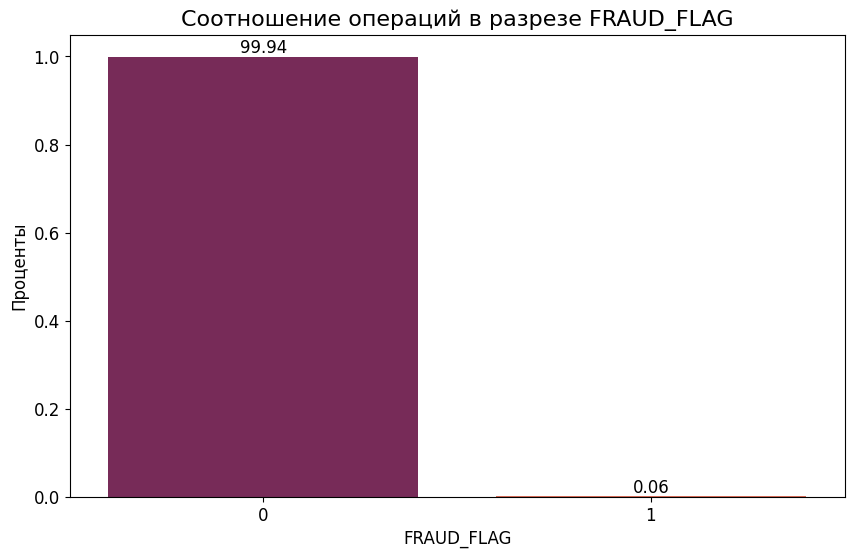

In [13]:
target_column = "FRAUD_FLAG"
norm_target = (df[target_column].value_counts(
    normalize=True).rename("percent").reset_index())

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=target_column,
                 y="percent",
                 palette='rocket',
                 data=norm_target)

for p in ax.patches:
    ax.annotate(
        format(p.get_height() * 100, '.2f'),  # текст
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 6),
        textcoords='offset points',
        fontsize=12)

plt.title("Соотношение операций в разрезе FRAUD_FLAG", fontsize=16)
plt.xlabel("FRAUD_FLAG", fontsize=12)
plt.ylabel("Проценты", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

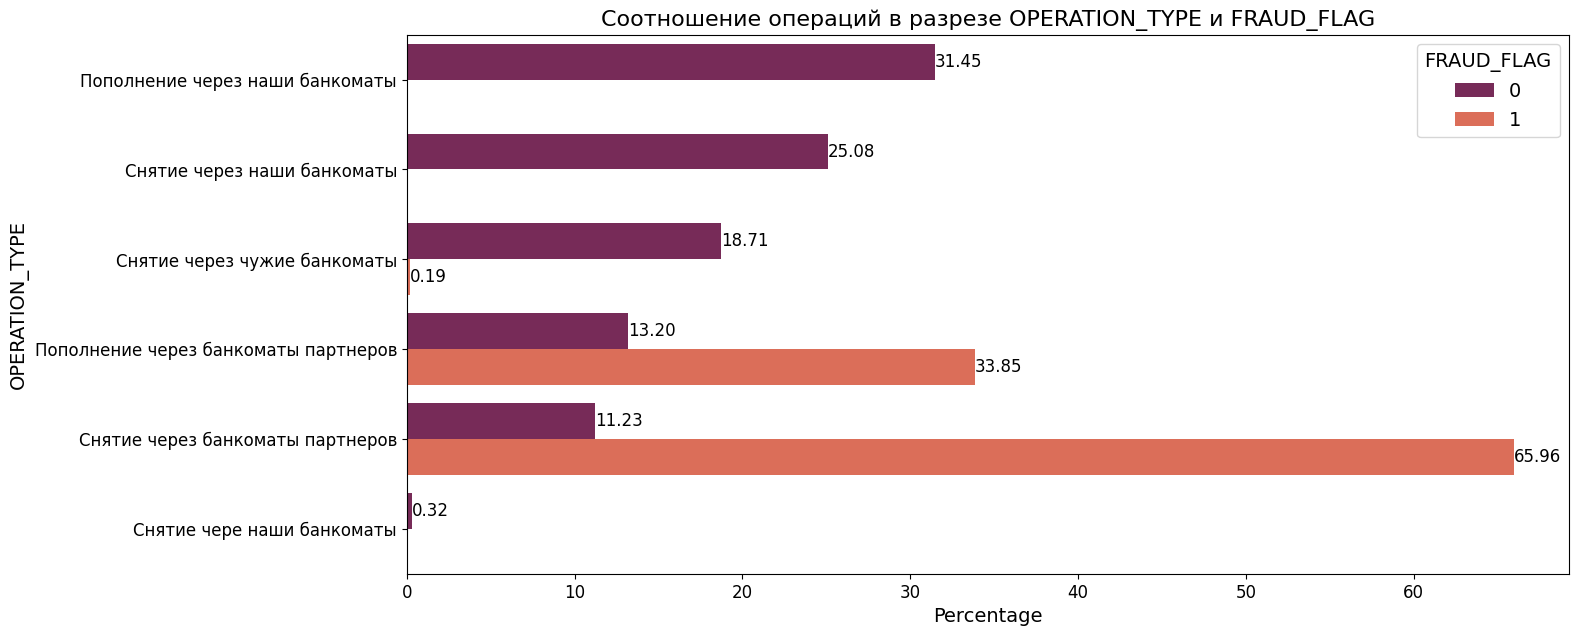

In [14]:
barplot_group(
    df_data=df,
    col_main="OPERATION_TYPE",
    col_group="FRAUD_FLAG",
    title= "Соотношение операций в разрезе OPERATION_TYPE и FRAUD_FLAG"
)

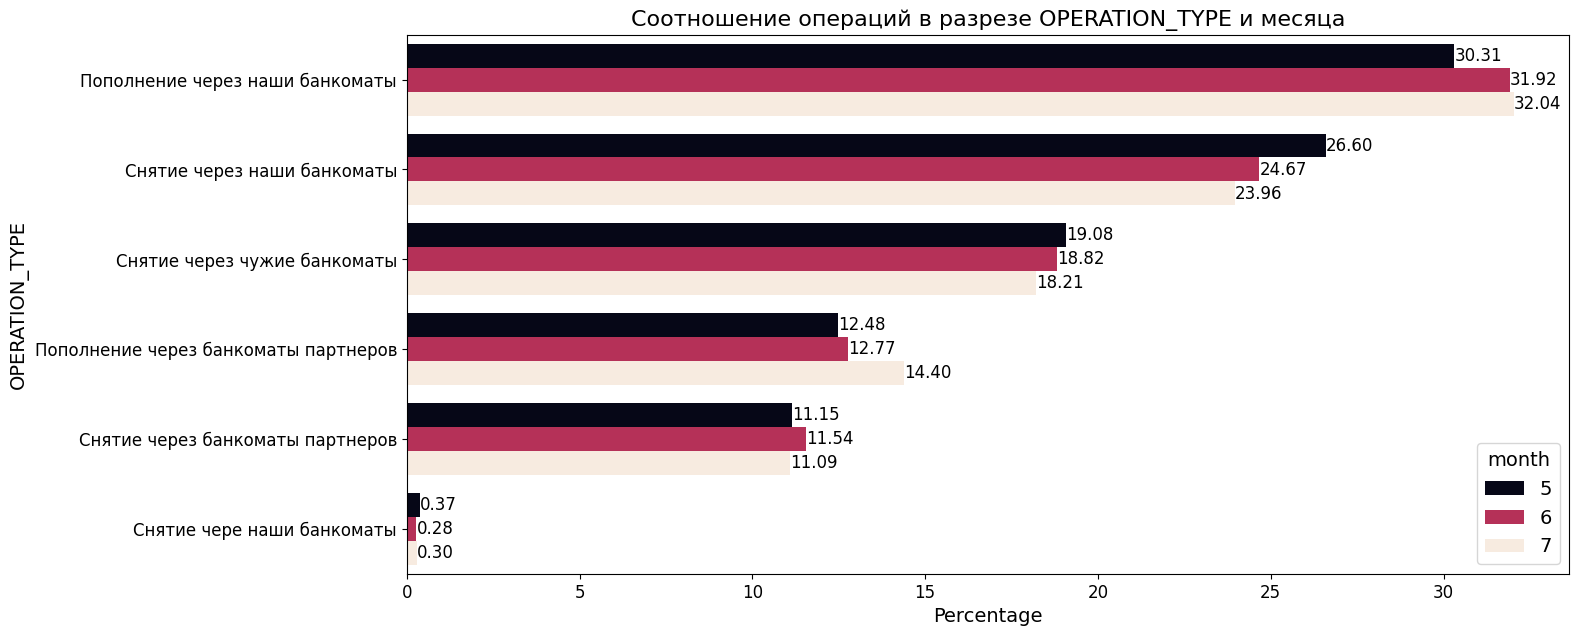

In [15]:
barplot_group(
    df_data=df,
    col_main="OPERATION_TYPE",
    col_group="month",
    title= "Соотношение операций в разрезе OPERATION_TYPE и месяца"
)

Посмотрим скоррелированы ли признаки Ид клиента и Город

In [18]:
def check_chi2(x: pd.Series, y: pd.Series, alpha: float = 0.05):
    """
    Проверка связи двух категориальных переменных
    """
    ct_table_ind = pd.crosstab(x, y)
    chi2_stat, p, dof, expected = stats.chi2_contingency(ct_table_ind)
    print(f"chi2 statistic: {chi2_stat:.5g}")
    print(f"p-value {p:.5g}")

    if p < alpha:
        print("Two categorical variables have a significant connection")
    else:
        print("Two categorical variables don't have a significant connection")


check_chi2(df['CITY'], df['CLIENT_ID'])

chi2 statistic: 3.099e+09
p-value 0
Two categorical variables have a significant connection


Признаки скорелированны

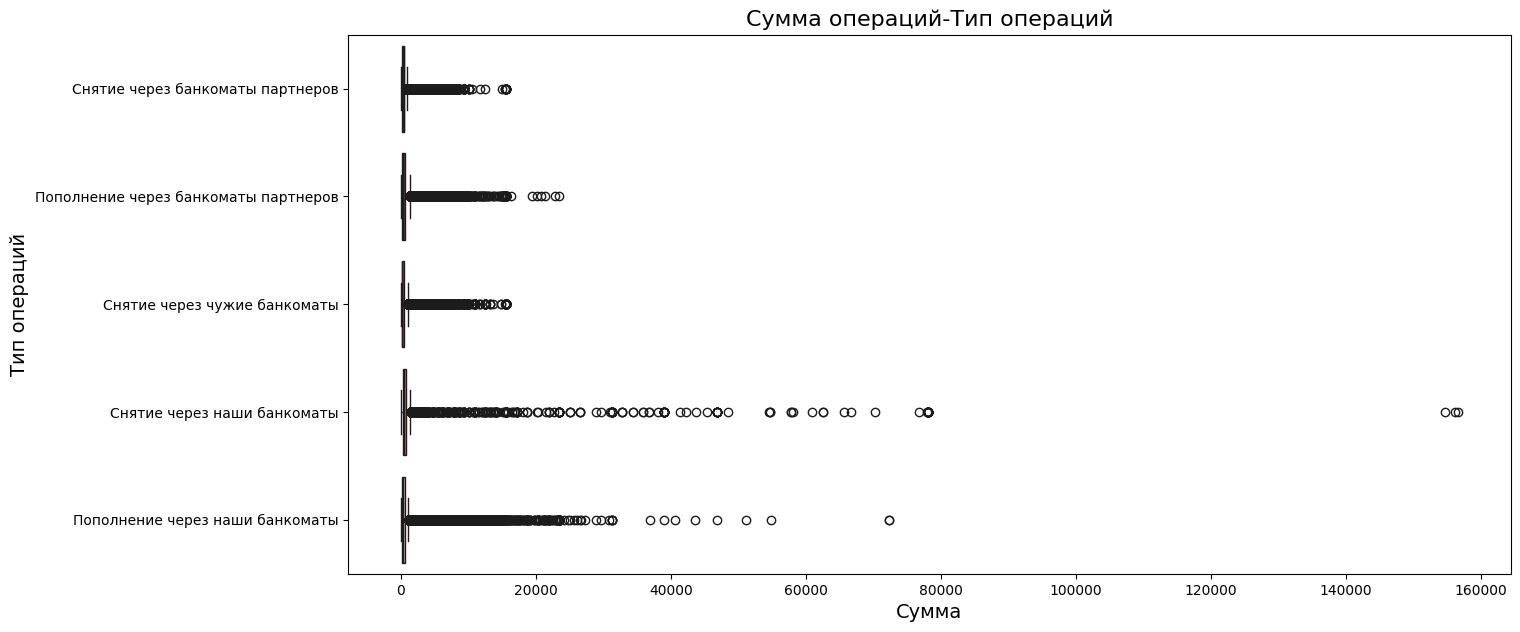

In [86]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='AMOUNT',
            y="OPERATION_TYPE",
            hue='OPERATION_TYPE',
            data=df,
            palette='rocket')

plt.title("Сумма операций-Тип операций", fontsize=16)
plt.xlabel('Сумма', fontsize=14)
plt.ylabel("Тип операций", fontsize=14)
plt.show()

Видим большие выбросы данных при снятии и пополнении через "наши" банкоматы, средние примерно равны

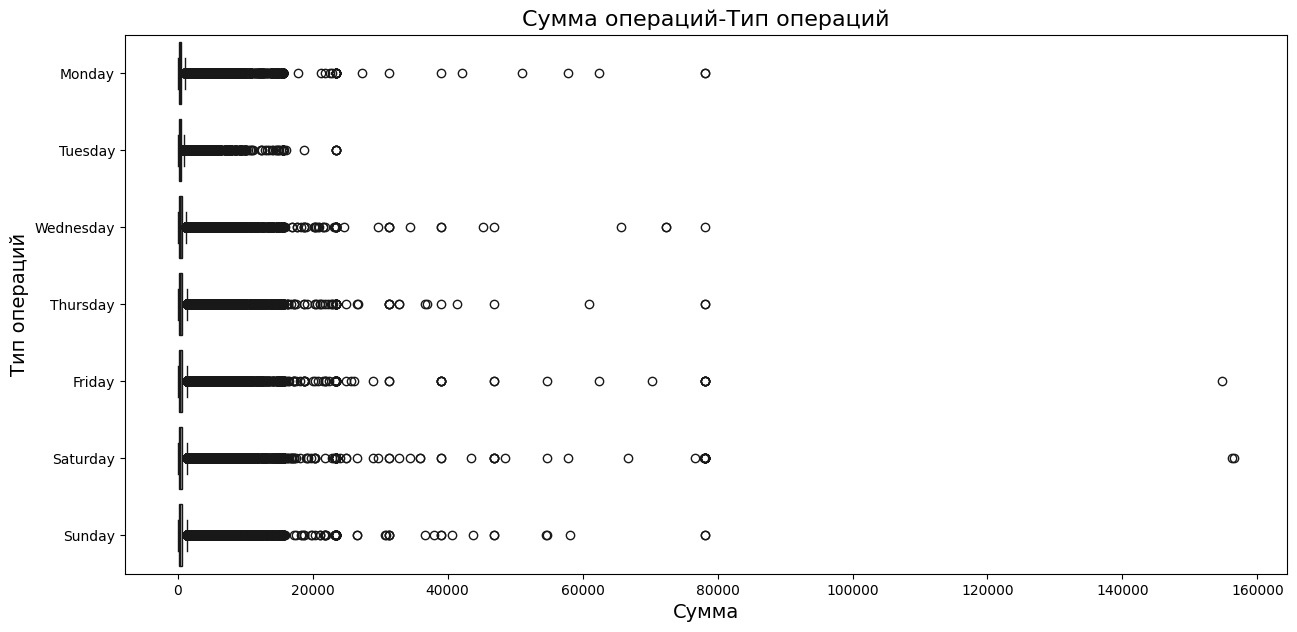

In [17]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='AMOUNT',
            y="day_of_week_name",
            hue='day_of_week_name',
            data=df,
            palette='rocket')

plt.title("Сумма операций-Тип операций", fontsize=16)
plt.xlabel('Сумма', fontsize=14)
plt.ylabel("Тип операций", fontsize=14)
plt.show()

## Динамика оборотов и кол-ва операций по банкам в разрезе месяца.

*Напишите запрос, который показывает динамику оборотов и кол-ва операций по банкам в разрезе месяца. Какие можно сделать выводы из полученного результата?*

Сначала посмотрим общие обороты и операции в разрезе месяца

In [23]:
df.groupby(['month'], observed=False).agg(    
    total_amount = ("AMOUNT", "sum"),  
    transactions_count = ("TRANSACTION_ID", "count")    
)

,total_amount,transactions_count
month,,
5,185582540,284944
6,185550380,299365
7,197750750,289534


In [ ]:
df.groupby(['month'], observed=False).agg({
    'AMOUNT': 'sum',
    'TRANSACTION_ID': 'count'
})

In [ ]:
df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True)

**Выводы**
- В целом нет большого разброса по оборатам и количесту операций, но видим что в июле(7) оборот был выше, а в июне(6) было больше операций

Можем также посмотреть отдельно для каждого банка

In [26]:
operations_group = df.groupby(['BANK_ID', 'month'], observed=False).agg(    
    total_amount = ("AMOUNT", "sum"),  
    transactions_count = ("TRANSACTION_ID", "count")    
)

operations_group[:10]

total_amount  transactions_count
BANK_ID month                                  
1       5         123245440              163436
        6         119906420              170483
        7         113390150              163204
2       5          10761540               26413
        6          11856220               28705
        7          11414060               26809
3       5          22473630               38938
        6          23682230               41712
        7          44771450               45866
4       5           4413120               13745

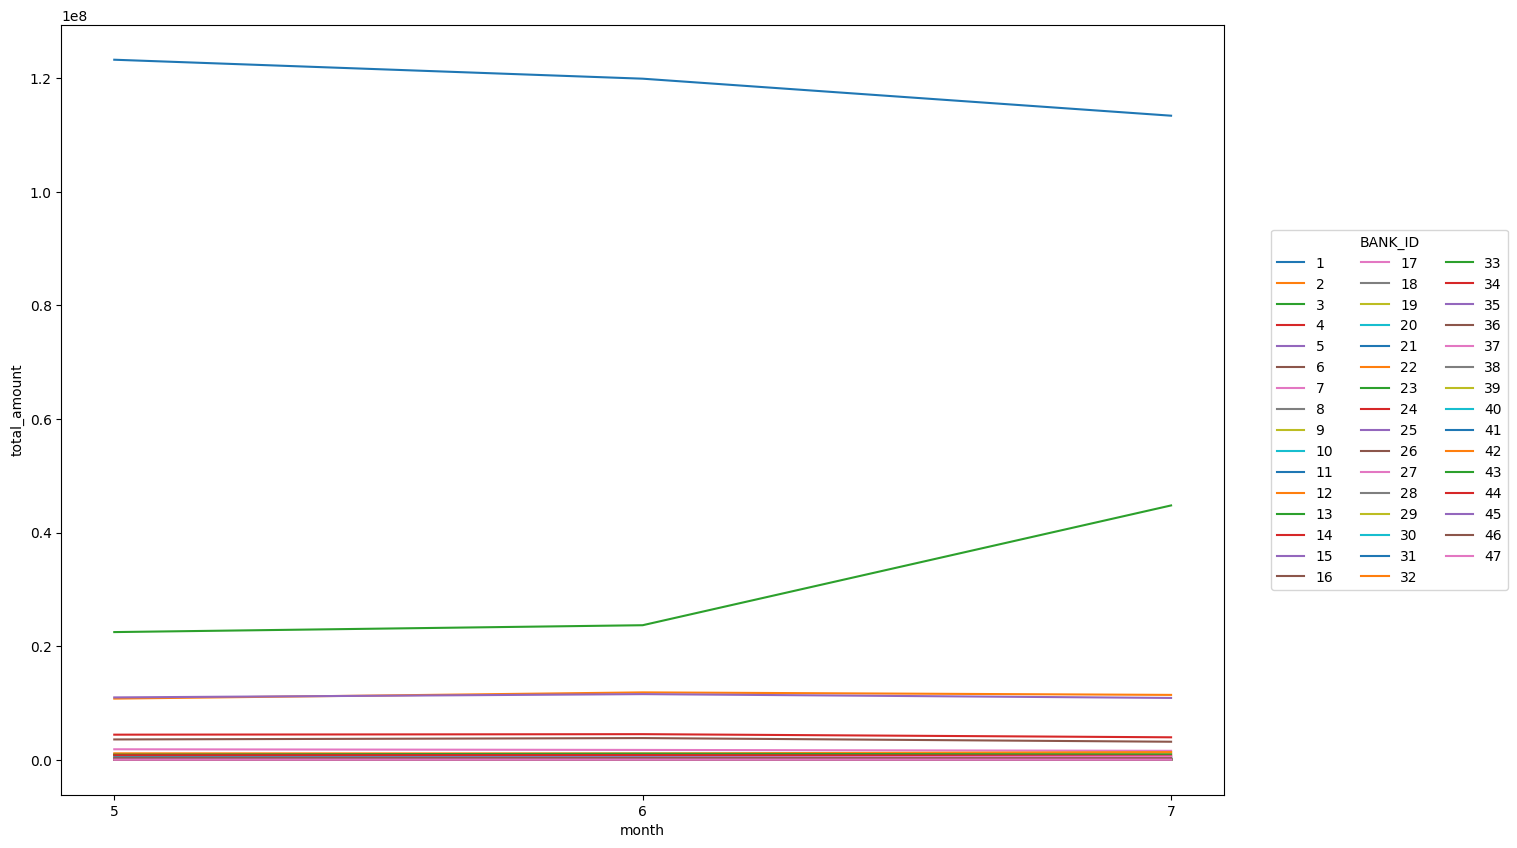

In [50]:
monthes = df.month.unique()
plt.figure(figsize=(15, 10))

ax = sns.lineplot(data=operations_group,
                  x='month',
                  y='total_amount',
                  hue="BANK_ID",                 
                  palette="tab10",
                 )

ax.set_xticks(df.month.unique())

sns.move_legend(ax, loc='center right', 
                bbox_to_anchor=(1.25, 0.5),                 
                ncol=3)
plt.show()

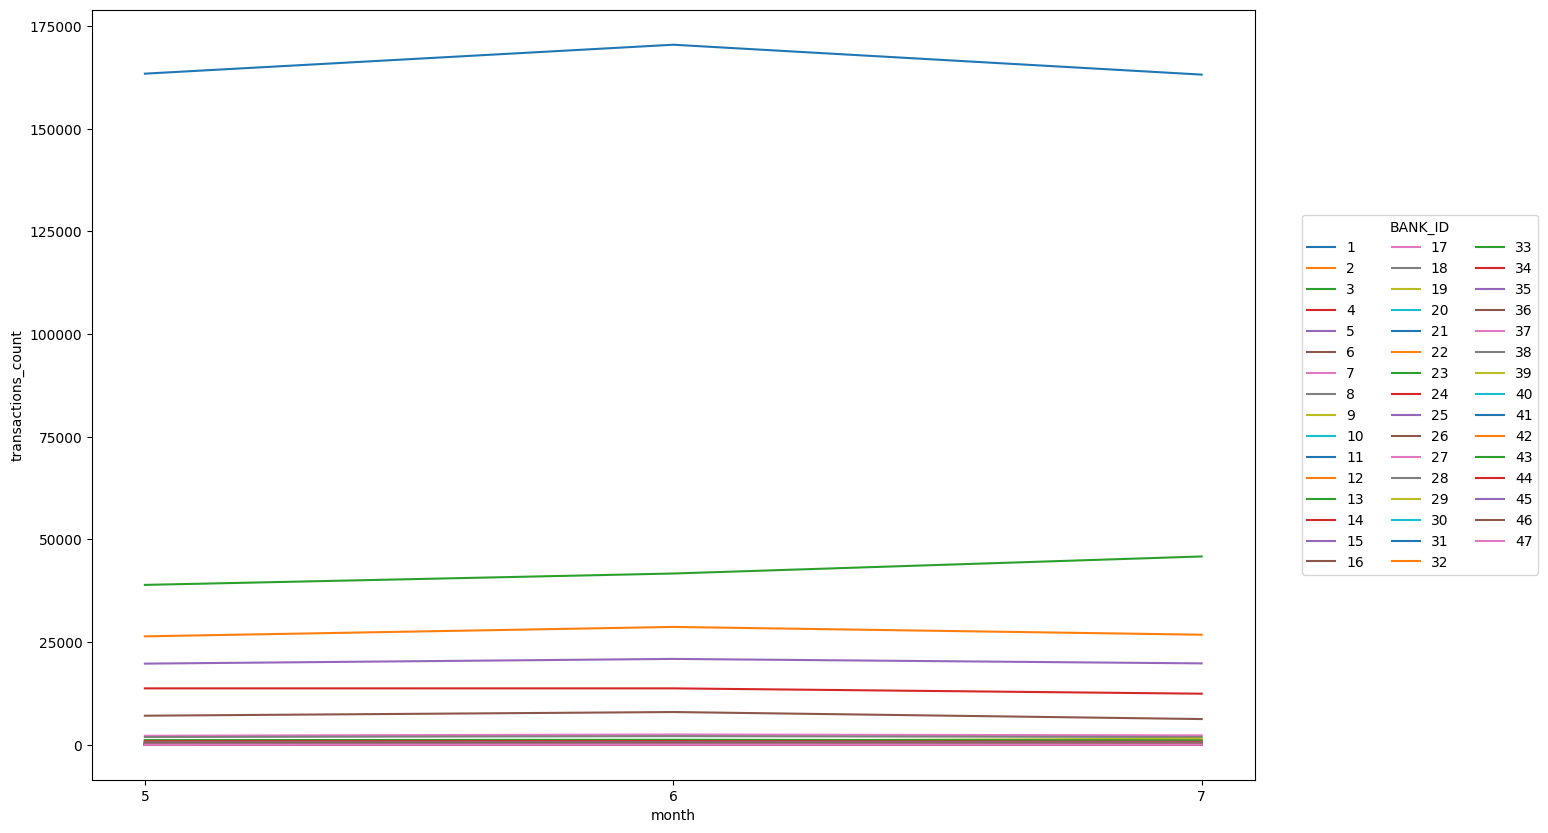

In [52]:
monthes = df.month.unique()
plt.figure(figsize=(15, 10))

ax = sns.lineplot(data=operations_group,
                  x='month',
                  y='transactions_count',
                  hue="BANK_ID",                 
                  palette="tab10",
                 )

ax.set_xticks(df.month.unique())

sns.move_legend(ax, loc='center right', 
                bbox_to_anchor=(1.25, 0.5),                 
                ncol=3)
plt.show()

**Выводы**
1. Видим, что оборот в банке с ИД = 1 значительно выше остальных банков
2. В целом динамика оборотов по банкам не сильно отличается в зависимости от месяца, за исключением некоторых банков(в банке с ИД=3 в июле месяце оборот выше)

## Процентный рост операций в разрезе банка, от месяца к месяцу.

*Напишите запрос, показывающий процентный рост операций в разрезе банка, от месяца к месяцу. Какой это был банк, какой тип операций и в каком месяце максимальный рост в % и в номинальных значениях оборота.*

Посмотрим на суммы и количество операций в разрезе банка в каждом месяце

In [45]:
operations_group = df.groupby(['BANK_ID', 'month'], observed=False).agg(
    total_amount=("AMOUNT", "sum"),
    transactions_count=("TRANSACTION_ID", "count"),
)

operations_group[:10]

total_amount  transactions_count
BANK_ID month                                  
1       5         123245440              163436
        6         119906420              170483
        7         113390150              163204
2       5          10761540               26413
        6          11856220               28705
        7          11414060               26809
3       5          22473630               38938
        6          23682230               41712
        7          44771450               45866
4       5           4413120               13745

Добавим информацию по предыдущим месяцам и сравним

In [54]:
operations_group["prev_amount"] = operations_group.groupby(
    "BANK_ID")["total_amount"].shift()
operations_group["prev_count"] = operations_group.groupby(
    "BANK_ID")["transactions_count"].shift()
operations_group["percentage_transactions_growth"] = operations_group["transactions_count"] / \
    operations_group["prev_count"]
operations_group["percentage_amount_growth"] = operations_group["total_amount"] / \
    operations_group["prev_amount"]
operations_group["transactions_diff"] = operations_group["transactions_count"] - \
    operations_group["prev_count"]
operations_group["amount_diff"] = operations_group["total_amount"] - \
    operations_group["prev_amount"]

operations_group[:5]

total_amount  transactions_count    prev_amount  prev_count  \
BANK_ID month                                                                
1       5         123245440              163436            NaN         NaN   
        6         119906420              170483 123245440.0000 163436.0000   
        7         113390150              163204 119906420.0000 170483.0000   
2       5          10761540               26413            NaN         NaN   
        6          11856220               28705  10761540.0000  26413.0000   

               percentage_transactions_growth  percentage_amount_growth  \
BANK_ID month                                                             
1       5                                 NaN                       NaN   
        6                              1.0431                    0.9729   
        7                              0.9573                    0.9457   
2       5                                 NaN                       NaN   
        6                              1.0868                    1.1017   

               transactions_diff   amount_diff  
BANK_ID month                                   
1       5                    NaN           NaN  
        6              7047.0000 -3339020.0000  
        7             -7279.0000 -6516270.0000  
2       5                    NaN           NaN  
        6              2292.0000  1094680.0000

Выведем топ 5 банков с максимальным ростом в % количества операций

In [60]:
operations_group.sort_values(by='percentage_transactions_growth',
                             ascending=False)[:5]

,,total_amount,transactions_count,prev_amount,prev_count,percentage_transactions_growth,percentage_amount_growth,transactions_diff,amount_diff
BANK_ID,month,,,,,,,,
35,7,49600,84,8120.0000,24.0000,3.5000,6.1084,60.0000,41480.0000
42,7,40000,131,35000.0000,55.0000,2.3818,1.1429,76.0000,5000.0000
29,7,7950,80,3490.0000,34.0000,2.3529,2.2779,46.0000,4460.0000
39,6,13570,58,6120.0000,29.0000,2.0000,2.2173,29.0000,7450.0000
47,6,14380,45,5180.0000,25.0000,1.8000,2.7761,20.0000,9200.0000


Выведем топ 5 банков с максимальным ростом в % суммы операций

In [63]:
operations_group.sort_values(by='percentage_amount_growth',
                             ascending=False)[:5]

,,total_amount,transactions_count,prev_amount,prev_count,percentage_transactions_growth,percentage_amount_growth,transactions_diff,amount_diff
BANK_ID,month,,,,,,,,
35,7,49600,84,8120.0000,24.0000,3.5000,6.1084,60.0000,41480.0000
47,6,14380,45,5180.0000,25.0000,1.8000,2.7761,20.0000,9200.0000
29,7,7950,80,3490.0000,34.0000,2.3529,2.2779,46.0000,4460.0000
39,6,13570,58,6120.0000,29.0000,2.0000,2.2173,29.0000,7450.0000
31,7,56910,122,27030.0000,72.0000,1.6944,2.1054,50.0000,29880.0000


Выведем топ 5 банков с максимальным ростом суммы операций

In [62]:
operations_group.sort_values(by='amount_diff', ascending=False)[:5]

total_amount  transactions_count   prev_amount  prev_count  \
BANK_ID month                                                               
3       7          44771450               45866 23682230.0000  41712.0000   
        6          23682230               41712 22473630.0000  38938.0000   
2       6          11856220               28705 10761540.0000  26413.0000   
5       6          11552540               20914 10972530.0000  19768.0000   
9       7           1250830                1494   952820.0000    987.0000   

               percentage_transactions_growth  percentage_amount_growth  \
BANK_ID month                                                             
3       7                              1.0996                    1.8905   
        6                              1.0712                    1.0538   
2       6                              1.0868                    1.1017   
5       6                              1.0580                    1.0529   
9       7                              1.5137                    1.3128   

               transactions_diff   amount_diff  
BANK_ID month                                   
3       7              4154.0000 21089220.0000  
        6              2774.0000  1208600.0000  
2       6              2292.0000  1094680.0000  
5       6              1146.0000   580010.0000  
9       7               507.0000   298010.0000

Посмотрим в разрезе типа операций

In [20]:
operations_group = df.groupby(['BANK_ID', 'month', "OPERATION_TYPE"],
                              observed=False).agg(
                                  total_amount=("AMOUNT", "sum"),
                                  transactions_count=("TRANSACTION_ID",
                                                      "count"),
                              )

operations_group.sort_values(by='total_amount', ascending=False)[:5]

total_amount  \
BANK_ID month OPERATION_TYPE                                  
1       5     Снятие через наши банкоматы          67889330   
        6     Пополнение через наши банкоматы      59767360   
        7     Пополнение через наши банкоматы      57950760   
        6     Снятие через наши банкоматы          56674560   
        5     Пополнение через наши банкоматы      52621770   

                                               transactions_count  
BANK_ID month OPERATION_TYPE                                       
1       5     Снятие через наши банкоматы                   75809  
        6     Пополнение через наши банкоматы               95549  
        7     Пополнение через наши банкоматы               92755  
        6     Снятие через наши банкоматы                   73858  
        5     Пополнение через наши банкоматы               86374

## Анализ клиентов с FRAUD_FLAG = 1

*Проведите анализ клиентов с FRAUD_FLAG = 1 и попробуйте понять, какие характеристики объединяют их.*

*Напишите запрос, позволяющий найти аналогичных клиентов, но с FRAUD_FLAG = 0.*

*Посчитайте долю операций таких клиентов от общей доли соответствующего типа операций в разрезе месяца.*

Для начала посмотрим на сами данные FRAUD_FLAG = 1

In [141]:
fraud_df = df.query("FRAUD_FLAG == 1")
print(fraud_df.shape)
fraud_df[:10]

(520, 12)


,TIME,TRANSACTION_ID,AMOUNT,CLIENT_ID,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG,month,day,day_of_week_name,hour
584677,2023-07-01 06:04:16,540482085666,1610,CE04E622F86F602C957FA020B1459F73ABBFF5A6A32746...,3,TUIMAZY G,Пополнение через банкоматы партнеров,1,7,1,Saturday,6
584682,2023-07-01 06:06:33,540517177893,80,CE04E622F86F602C957FA020B1459F73ABBFF5A6A32746...,3,TUIMAZY G,Пополнение через банкоматы партнеров,1,7,1,Saturday,6
595805,2023-07-02 05:55:05,540668745645,470,CE04E622F86F602C957FA020B1459F73ABBFF5A6A32746...,3,TUIMAZY G,Снятие через банкоматы партнеров,1,7,2,Sunday,5
595808,2023-07-02 05:55:55,540680353065,470,CE04E622F86F602C957FA020B1459F73ABBFF5A6A32746...,3,TUIMAZY G,Снятие через банкоматы партнеров,1,7,2,Sunday,5
595809,2023-07-02 05:56:47,540678903347,470,CE04E622F86F602C957FA020B1459F73ABBFF5A6A32746...,3,TUIMAZY G,Снятие через банкоматы партнеров,1,7,2,Sunday,5
595817,2023-07-02 05:57:45,540672053985,160,CE04E622F86F602C957FA020B1459F73ABBFF5A6A32746...,3,TUIMAZY G,Снятие через банкоматы партнеров,1,7,2,Sunday,5
599124,2023-07-02 11:22:31,540645052881,500,B9983326ADA8FB296B488236557DE7A1FADB49300C4C82...,3,NALCHIK G,Пополнение через банкоматы партнеров,1,7,2,Sunday,11
599162,2023-07-02 11:24:31,540678407251,470,B9983326ADA8FB296B488236557DE7A1FADB49300C4C82...,3,NALCHIK G,Снятие через банкоматы партнеров,1,7,2,Sunday,11
599195,2023-07-02 11:25:37,540671389967,470,B9983326ADA8FB296B488236557DE7A1FADB49300C4C82...,3,NALCHIK G,Пополнение через банкоматы партнеров,1,7,2,Sunday,11
599225,2023-07-02 11:26:54,540640594084,470,B9983326ADA8FB296B488236557DE7A1FADB49300C4C82...,3,NALCHIK G,Снятие через банкоматы партнеров,1,7,2,Sunday,11


In [166]:
fraud_df.groupby(["CLIENT_ID", "month", "day"])[
    "TRANSACTION_ID"].filter(lambda x: x.nunique() > 1).shape

(512,)

In [199]:
cols = ["BANK_ID", "CITY", "OPERATION_TYPE", "month", "CLIENT_ID"]
for col in cols:
    print(fraud_df[col].value_counts(normalize=True))
    print()

BANK_ID
3    0.5673
5    0.3577
6    0.0519
20   0.0212
4    0.0019
Name: proportion, dtype: float64

CITY
Visa Direct     0.0577
EKATERINBURG    0.0538
MOSKVA          0.0500
PENZA           0.0423
UKHTA G         0.0385
TOMSK G         0.0365
SANKT PETERBU   0.0327
KRASNODAR       0.0288
GRIAZI G        0.0250
ASTRAKHAN G     0.0250
NOVOSHAKHTINS   0.0192
NALCHIK G       0.0192
TULA            0.0192
KRASNODAR G     0.0192
KHIMKI G        0.0192
PENZA G         0.0192
ROSTOV NA DON   0.0173
CHEBOKSARY G    0.0173
SMOLENSK G      0.0173
IRKUTSK         0.0154
SOVKHOZA IM     0.0154
G PENZA         0.0154
STARAYA RUSSA   0.0154
MEZHDURECHENS   0.0154
KOSTROMA G      0.0154
VOLGOGRAD       0.0135
NOVOSIBIRSK     0.0135
TAMBOV G        0.0135
CHITA           0.0135
BATAYSK         0.0135
MIKHAILOVSK G   0.0135
OBNINSK         0.0135
SARANSK G       0.0115
NOVOROSSIISK    0.0115
KANDALAKSHA G   0.0115
RYBINSK G       0.0115
UFA             0.0115
NOVOSIBIRSK G   0.0115
MURMANSK G      0.0

In [188]:
df[["FRAUD_FLAG", "AMOUNT", "OPERATION_TYPE"]].groupby(["FRAUD_FLAG", "OPERATION_TYPE"]).describe().T

FRAUD_FLAG                                        0  \
OPERATION_TYPE Пополнение через банкоматы партнеров   
AMOUNT count                            115312.0000   
       mean                                673.9239   
       std                                1254.9225   
       min                                   0.0000   
       25%                                 130.0000   
       50%                                 270.0000   
       75%                                 640.0000   
       max                               23360.0000   

FRAUD_FLAG                                      \
OPERATION_TYPE Пополнение через наши банкоматы   
AMOUNT count                       274678.0000   
       mean                           620.1439   
       std                           1420.9475   
       min                              0.0000   
       25%                            160.0000   
       50%                            280.0000   
       75%                            550.0000   
       max                          72340.0000   

FRAUD_FLAG                                                                   \
OPERATION_TYPE Снятие через банкоматы партнеров Снятие через наши банкоматы   
AMOUNT count                         98095.0000                 221796.0000   
       mean                            619.3224                    838.6099   
       std                             952.8288                   1589.5895   
       min                              10.0000                     10.0000   
       25%                             200.0000                    300.0000   
       50%                             410.0000                    470.0000   
       75%                             470.0000                    750.0000   
       max                           15630.0000                 156590.0000   

FRAUD_FLAG                                   \
OPERATION_TYPE Снятие через чужие банкоматы   
AMOUNT count                    163442.0000   
       mean                        451.5245   
       std                         828.6406   
       min                          10.0000   
       25%                         120.0000   
       50%                         230.0000   
       75%                         470.0000   
       max                       15630.0000   

FRAUD_FLAG                                        1  \
OPERATION_TYPE Пополнение через банкоматы партнеров   
AMOUNT count                               176.0000   
       mean                                801.1364   
       std                                 732.8285   
       min                                  20.0000   
       25%                                 290.0000   
       50%                                 470.0000   
       75%                                1330.0000   
       max                                3830.0000   

FRAUD_FLAG                                                                    
OPERATION_TYPE Снятие через банкоматы партнеров Снятие через чужие банкоматы  
AMOUNT count                           343.0000                       1.0000  
       mean                            409.1254                     130.0000  
       std                             149.6403                          NaN  
       min                               0.0000                     130.0000  
       25%                             375.0000                     130.0000  
       50%                             470.0000                     130.0000  
       75%                             470.0000                     130.0000  
       max                            1560.0000                     130.0000

**Можно увидеть следующие закономерности**:
- Как правило это несколько подряд идущих операций в день
- Top 2 банка с FRAUD_FLAG = 1 - 3 и 5
- OPERATION_TYPE чаще всего - Снятие через банкоматы партнеров или Пополнение через банкоматы партнеров
- Для некоторых клиентов много операций FRAUD_FLAG, для части - единичные случаи
- Сумма операции в среднем не превышает 500 рублей

Доля операций таких клиентов

In [170]:
operation_types = fraud_df.OPERATION_TYPE.unique()
df[df['OPERATION_TYPE'].isin(operation_types)].groupby(["month", "OPERATION_TYPE"])["FRAUD_FLAG"].value_counts(normalize=True)

month  OPERATION_TYPE                        FRAUD_FLAG
5      Пополнение через банкоматы партнеров  0            1.0000
       Снятие через банкоматы партнеров      0            1.0000
       Снятие через чужие банкоматы          0            1.0000
6      Пополнение через банкоматы партнеров  0            1.0000
       Снятие через банкоматы партнеров      0            1.0000
       Снятие через чужие банкоматы          0            1.0000
7      Пополнение через банкоматы партнеров  0            0.9958
                                             1            0.0042
       Снятие через банкоматы партнеров      0            0.9893
                                             1            0.0107
       Снятие через чужие банкоматы          0            1.0000
                                             1            0.0000
Name: proportion, dtype: float64

Поиск аналогичных клиентов, но с FRAUD_FLAG = 0.

In [190]:
fraud_possible_df = df[df['OPERATION_TYPE'].isin(operation_types)
                       & df["BANK_ID"].isin([3, 5])].groupby([
                           "CLIENT_ID", "month", "day"
                       ]).filter(lambda x: x["TRANSACTION_ID"].nunique() > 1)

print(fraud_possible_df.shape)
fraud_possible_df[:5]

(86295, 12)


,TIME,TRANSACTION_ID,AMOUNT,CLIENT_ID,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG,month,day,day_of_week_name,hour
10,2023-05-01 00:33:48,525503786058,110,067866C83BB46B1356543FEDA6615B1A967496A433EDBA...,5,USSURIYSK,Снятие через банкоматы партнеров,0,5,1,Monday,0
12,2023-05-01 00:45:29,525371179679,230,94045251509AEF6F57018480BF5B80AA8E53F398B101DC...,3,VLADIVOSTOK G,Пополнение через банкоматы партнеров,0,5,1,Monday,0
43,2023-05-01 01:58:29,525487625369,470,F2897E4E171270FCA5DFC85F9F76FAD0E17300FD90B6D3...,3,PETROZAVODSK,Снятие через банкоматы партнеров,0,5,1,Monday,1
45,2023-05-01 01:59:51,525509002451,470,F2897E4E171270FCA5DFC85F9F76FAD0E17300FD90B6D3...,3,PETROZAVODSK,Снятие через банкоматы партнеров,0,5,1,Monday,1
58,2023-05-01 02:41:56,525334915146,550,116F478F4BDDE84FEA9DDF09D550F2AD3646F52B4BDA33...,3,CHISTOPOL G,Пополнение через банкоматы партнеров,0,5,1,Monday,2


Посмотрим, насколько ИД клиентов совпадают

In [194]:
print(fraud_df[fraud_df['CLIENT_ID'].isin(
    fraud_possible_df.CLIENT_ID.unique())].shape)

print(fraud_possible_df[fraud_possible_df['CLIENT_ID'].isin(
    fraud_df.CLIENT_ID.unique())].shape)

(502, 12)
(1112, 12)


Видим только частичное совпадение

Можно еще усилить условия, например, несколько операций в течение часа.


In [203]:
groupby_client = fraud_df.groupby('CLIENT_ID')
fraud_df["prev_diff"] = (fraud_df["TIME"] - groupby_client['TIME'].shift(1)).dt.seconds
fraud_df["next_diff"] = (fraud_df["TIME"] - groupby_client['TIME'].shift(-1)).dt.seconds

In [206]:
fraud_df.query("prev_diff <= 360 or next_diff <= 360").groupby(["CLIENT_ID", "month", "day"])[
    "TRANSACTION_ID"].filter(lambda x: x.nunique() > 1).shape

(411,)